In [1]:
from scipy import signal
from scipy.interpolate import BSpline, make_interp_spline
import matplotlib.pyplot as plt
import neurokit2 as nk
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import skfda
from texttable import Texttable
import sys
import random
import time
import statsmodels.api as sm
from skfda.exploratory.visualization import Boxplot
from skfda.preprocessing.dim_reduction.projection import FPCA

sys.path.append("..")
from fda import *


In [2]:
def centeredFiniteDistance2D(x, y):
    even = y[:, ::2]
    odd = y[:, 1::2]

    dx = np.diff(x)[0]

    d_odd = np.diff(odd) / (2 * dx)
    d_even = np.diff(even) / (2 * dx)

    z = np.zeros((y.shape[0], y.shape[1] - 2))
    z[:, ::2] = d_even
    z[:, 1::2] = d_odd
    return z


def compute_knots2(peakList=[0.0, 1.0], n_chebyshev=20, sampling_rate=500):
    if len(peakList) < 9:
        raise Exception(
            "Input list too short({}), expected to be 9".format(len(peakList))
        )
    start = peakList[0]
    stop = peakList[-1]
    middle = peakList[4]
    t_points = np.linspace(0, (stop - start) / sampling_rate, int((stop - start)))

    chebyshev = np.polynomial.chebyshev.chebpts1(n_chebyshev * 2)
    cheb_start = chebyshev[int(len(chebyshev) / 2) :]
    cheb_stop = chebyshev[: int(len(chebyshev) / 2)]

    a = np.interp(chebyshev, (cheb_start.min(), cheb_start.max()), (start, middle))
    b = np.interp(chebyshev, (cheb_stop.min(), cheb_stop.max()), (middle, stop))

    knots = np.concatenate((a, b, np.array(peakList)))
    knots = np.unique(knots)
    knots = np.sort(knots)
    knots = (knots - start) / sampling_rate

    return knots, t_points



In [3]:
ENV_FIGURES = False
SAMPLING_RATE = 500
N_CHEB = 21
LEAD = 0
BEAT = 0


In [4]:
# load datasets
F = pd.read_csv(data_processed + "femaleH.csv", index_col="ecg_id")
M = pd.read_csv(data_processed + "maleH.csv", index_col="ecg_id")

# load ECG interval data
waves_F = np.load(data_processed + "waves_F.npy")
waves_M = np.load(data_processed + "waves_M.npy")

# load ECG signals
ecgM = load_raw_data(M, SAMPLING_RATE, data_raw)
ecgF = load_raw_data(F, SAMPLING_RATE, data_raw)


In [5]:
PATIENT_F = random.choices(range(waves_F.shape[0]), k=5)
PATIENT_M = random.choices(range(waves_M.shape[0]), k=5)

bins = [7, 12, 19, 24]
PATIENT_F_0_7 = [i for i, v in enumerate(F.Hour) if (v < 7)]
PATIENT_M_0_7 = [i for i, v in enumerate(M.Hour) if (v < 7)]
PATIENT_F_7_12 = [i for i, v in enumerate(F.Hour) if (v >= 7) & (v <= 12)]
PATIENT_M_7_12 = [i for i, v in enumerate(M.Hour) if (v >= 7) & (v <= 12)]
PATIENT_F_12_19 = [i for i, v in enumerate(F.Hour) if (v > 12) & (v <= 19)]
PATIENT_M_12_19 = [i for i, v in enumerate(M.Hour) if (v > 12) & (v <= 19)]
PATIENT_F_19_24 = [i for i, v in enumerate(F.Hour) if (v > 19) & (v <= 24)]
PATIENT_M_19_24 = [i for i, v in enumerate(M.Hour) if (v > 19) & (v <= 24)]


In [6]:
def smoothedECG(
    ECG,
    intervals,
    show_figures=False,
    sampling_rate=SAMPLING_RATE,
    _beat=BEAT,
    _n_cheb=N_CHEB,
):
    # cut heartbeat from patient's ECG
    peakList = [el[_beat] for el in intervals]
    start = int(peakList[0])
    stop = int(peakList[-1])
    knots, t_points = compute_knots2(peakList, _n_cheb)

    # create skfda 's FDataGrid data
    heartbeatRaw = skfda.FDataGrid(
        ECG[start:stop, LEAD] - np.mean(ECG[start:stop, LEAD]),
        t_points,
        dataset_name="ECG lead " + str(_beat + 1),
        argument_names=["time"],
        coordinate_names=["mV"],
    )
    # compute basis
    N_BASIS = len(knots) + 2
    basis = skfda.representation.basis.BSpline(
        n_basis=N_BASIS, domain_range=[knots[0], knots[-1]], knots=knots
    )
    # basis.plot()

    # compute smoother
    smoother = skfda.preprocessing.smoothing.BasisSmoother(basis, method="cholesky")

    # compute smoothed curve
    heartbeatSmoothed = smoother.fit_transform(heartbeatRaw)

    y = heartbeatSmoothed.data_matrix[0, :, 0]

    # interpolation to obtain the same number of samples
    f = make_interp_spline(t_points, y)
    new_t = np.linspace(0, t_points[-1], y.shape[0])
    y_new = f(new_t).T

    # plot raw + smoothed ECG
    if show_figures:
        plt.figure()
        plt.plot(t_points, heartbeatRaw.data_matrix[0, :, 0], label="ECG raw")
        # plt.plot(t_points, heartbeatSmoothed.data_matrix[0, :, 0], label="ECG smoothed")
        plt.plot(new_t, y_new)
        plt.legend()
        plt.show()

    return y



In [7]:
def getLandmarks(waveList, patientList, sampling_rate=SAMPLING_RATE):
    peak = waveList[patientList, :, 0]
    sub = peak[:, 0]

    peak = [(peak[:, i] - peak[:, 0]) / sampling_rate for i in range(peak.shape[1])]
    peak = np.transpose(np.array(peak))
    peak = peak[:, 2:8]

    return np.array(peak)



In [8]:
smoothed_F_0_7 = [
    smoothedECG(ecgF[p], waves_F[p], show_figures=False) for p in PATIENT_F_0_7
]
smoothed_F_7_12 = [
    smoothedECG(ecgF[p], waves_F[p], show_figures=False) for p in PATIENT_F_7_12
]
smoothed_F_12_19 = [
    smoothedECG(ecgF[p], waves_F[p], show_figures=False) for p in PATIENT_F_12_19
]
smoothed_F_19_24 = [
    smoothedECG(ecgF[p], waves_F[p], show_figures=False) for p in PATIENT_F_19_24
]


smoothed_M_0_7 = [
    smoothedECG(ecgM[p], waves_M[p], show_figures=False) for p in PATIENT_M_0_7
]
smoothed_M_7_12 = [
    smoothedECG(ecgM[p], waves_M[p], show_figures=False) for p in PATIENT_M_7_12
]
smoothed_M_12_19 = [
    smoothedECG(ecgM[p], waves_M[p], show_figures=False) for p in PATIENT_M_12_19
]
smoothed_M_19_24 = [
    smoothedECG(ecgM[p], waves_M[p], show_figures=False) for p in PATIENT_M_19_24
]

# max samples are 484
maxSamples_F_0_7 = max(map(len, smoothed_F_0_7))
maxSamples_F_7_12 = max(map(len, smoothed_F_7_12))
maxSamples_F_12_19 = max(map(len, smoothed_F_12_19))
maxSamples_F_19_24 = max(map(len, smoothed_F_19_24))

maxSamples_M_0_7 = max(map(len, smoothed_M_0_7))
maxSamples_M_7_12 = max(map(len, smoothed_M_7_12))
maxSamples_M_12_19 = max(map(len, smoothed_M_12_19))
maxSamples_M_19_24 = max(map(len, smoothed_M_19_24))

maxSamples_0_7 = max([maxSamples_F_0_7, maxSamples_M_0_7])
maxSamples_7_12 = max([maxSamples_F_7_12, maxSamples_M_7_12])
maxSamples_12_19 = max([maxSamples_F_12_19, maxSamples_M_12_19])
maxSamples_19_24 = max([maxSamples_F_19_24, maxSamples_M_19_24])

maxSamples = max([maxSamples_0_7, maxSamples_7_12, maxSamples_12_19, maxSamples_19_24])
t = np.linspace(0, maxSamples * (1 / SAMPLING_RATE), maxSamples)


In [9]:
def padSamples(sample, length):
    for i in range(len(sample)):
        x = sample[i]
        xc = x[-1] * np.ones(length - x.size)
        sample[i] = np.concatenate((x, xc))
        sample[i] = skfda.representation.grid.FDataGrid(sample[i])
    return sample



In [10]:
smoothed_F_0_7 = padSamples(smoothed_F_0_7, maxSamples)
smoothed_F_7_12 = padSamples(smoothed_F_7_12, maxSamples)
smoothed_F_12_19 = padSamples(smoothed_F_12_19, maxSamples)
smoothed_F_19_24 = padSamples(smoothed_F_19_24, maxSamples)

smoothed_M_0_7 = padSamples(smoothed_M_0_7, maxSamples)
smoothed_M_7_12 = padSamples(smoothed_M_7_12, maxSamples)
smoothed_M_12_19 = padSamples(smoothed_M_12_19, maxSamples)
smoothed_M_19_24 = padSamples(smoothed_M_19_24, maxSamples)


In [11]:
def concatenateFDataGrid(a, b):
    if a:
        fd = a[0]
        for fi in range(len(a)):
            if fi > 0:
                fd = fd.concatenate(a[fi])
    if b:
        for mi in range(len(b)):
            fd = fd.concatenate(b[mi])
    return fd



In [12]:
# Cambiando land e smooth cambiamo orario

smoothed_F_7_12 = smoothed_F_12_19
smoothed_M_7_12 = smoothed_M_12_19

PATIENT_F_7_12 = PATIENT_F_12_19
PATIENT_M_7_12 = PATIENT_M_12_19

# smoothed_F_7_12 = smoothed_F_7_12
# smoothed_M_7_12 = smoothed_M_7_12

# PATIENT_F_7_12 = PATIENT_F_7_12
# PATIENT_M_7_12 = PATIENT_M_7_12



In [13]:

fd_7_12 = concatenateFDataGrid(smoothed_F_7_12, smoothed_M_7_12)


In [14]:

land_F_7_12 = getLandmarks(waves_F, PATIENT_F_7_12, sampling_rate=SAMPLING_RATE)
land_M_7_12 = getLandmarks(waves_M, PATIENT_M_7_12, sampling_rate=SAMPLING_RATE)
land_7_12 = np.concatenate([land_F_7_12, land_M_7_12])


([<matplotlib.axis.XTick at 0x7fcfe492d160>,
 [Text(0.15884768211920533, 0, 'P'),
  Text(0.260887417218543, 0, 'Q'),
  Text(0.2950198675496689, 0, 'R'),
  Text(0.3258807947019867, 0, 'S'),
  Text(0.5425298013245033, 0, 'T'),
  Text(0.613682119205298, 0, 'TOff')])

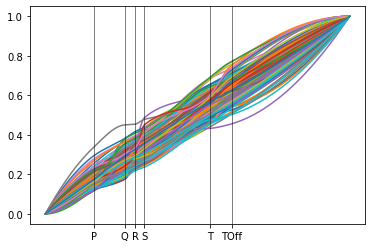

In [15]:
warping_7_12 = skfda.preprocessing.registration.landmark_registration_warping(
    fd_7_12, land_7_12, location=np.mean(land_M_7_12, axis=0)
)

fig = warping_7_12.plot()

for v in np.mean(land_7_12, axis=0):
    plt.axvline(x=v, color="k", lw=0.5)

plt.xticks(np.mean(land_7_12, axis=0), ["P", "Q", "R", "S", "T", "TOff"])


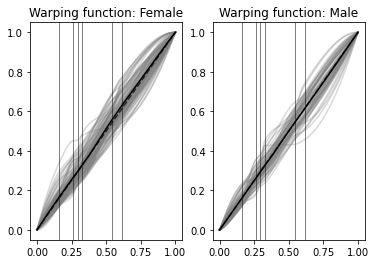

In [16]:
tw = np.array(warping_7_12.grid_points)
xf = warping_7_12.data_matrix[: len(land_F_7_12), :, 0]
xm = warping_7_12.data_matrix[len(land_F_7_12) :, :, 0]

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.set_title("Warping function: Female")
ax2.set_title("Warping function: Male")

for i in range(len(xf)):
    ax1.plot(tw[0, :], xf[i, :], color="gray", alpha=0.3)
bis = np.linspace(0, 1, 500)
ax1.plot(bis, bis, "k--", alpha=0.7)
ax1.plot(tw[0, :], np.mean(xf, axis=0), color="k")
for v in np.mean(land_7_12, axis=0):
    ax1.axvline(x=v, color="k", lw=0.5)

for i in range(len(xm)):
    ax2.plot(tw[0, :], xm[i, :], color="gray", alpha=0.3)
bis = np.linspace(0, 1, 500)
ax2.plot(bis, bis, "k--", alpha=0.7)
ax2.plot(tw[0, :], np.mean(xm, axis=0), color="k")
for v in np.mean(land_7_12, axis=0):
    ax2.axvline(x=v, color="k", lw=0.5)


Text(0.5, 1.0, 'Subjects 07-12')

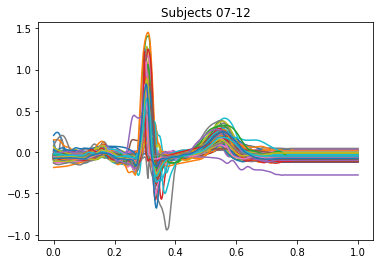

In [17]:
fd_registered_7_12 = fd_7_12.compose(warping_7_12)
fig = fd_registered_7_12.plot()
plt.title("Subjects 07-12")


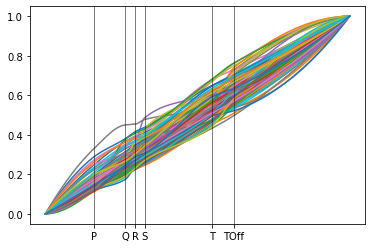

In [18]:
fd_F_7_12 = concatenateFDataGrid(smoothed_F_7_12, None)
warping_F_7_12 = skfda.preprocessing.registration.landmark_registration_warping(
    fd_F_7_12, land_F_7_12, location=np.mean(land_F_7_12, axis=0)
)

fig = warping_F_7_12.plot()

for v in np.mean(land_F_7_12, axis=0):
    plt.axvline(x=v, color="k", lw=0.5)

plt.xticks(np.mean(land_F_7_12, axis=0), ["P", "Q", "R", "S", "T", "TOff"])
fd_registered_F_7_12 = fd_F_7_12.compose(warping_F_7_12)


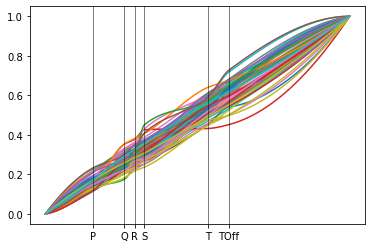

In [19]:
fd_M_7_12 = concatenateFDataGrid(smoothed_M_7_12, None)
warping_M_7_12 = skfda.preprocessing.registration.landmark_registration_warping(
    fd_M_7_12, land_M_7_12, location=np.mean(land_M_7_12, axis=0)
)

fig = warping_M_7_12.plot()

for v in np.mean(land_M_7_12, axis=0):
    plt.axvline(x=v, color="k", lw=0.5)

plt.xticks(np.mean(land_M_7_12, axis=0), ["P", "Q", "R", "S", "T", "TOff"])
fd_registered_M_7_12 = fd_M_7_12.compose(warping_M_7_12)


([<matplotlib.axis.XTick at 0x7fcfc03d28e0>,
 [Text(79.42384105960267, 0, 'P'),
  Text(130.4437086092715, 0, 'Q'),
  Text(147.50993377483445, 0, 'R'),
  Text(162.94039735099335, 0, 'S'),
  Text(271.26490066225165, 0, 'T'),
  Text(306.841059602649, 0, 'TOff')])

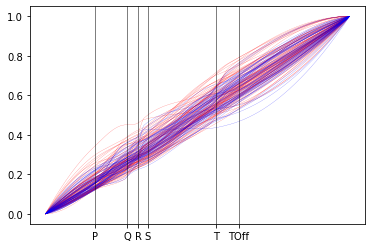

In [20]:
fig = plt.figure()
for i in range(warping_7_12.n_samples):
    if i < len(land_F_7_12):
        plt.plot(
            warping_7_12.data_matrix[i, :, 0],
            "r",
            alpha=0.7,
            linewidth=0.2,
            label="Female",
        )
    else:
        plt.plot(
            warping_7_12.data_matrix[i, :, 0],
            "b",
            alpha=0.7,
            linewidth=0.2,
            label="Male",
        )
for v in np.mean(land_7_12, axis=0):
    plt.axvline(x=v * SAMPLING_RATE, color="k", lw=0.5)

plt.xticks(
    np.mean(land_7_12, axis=0) * SAMPLING_RATE, ["P", "Q", "R", "S", "T", "TOff"]
)
# plt.legend()


([<matplotlib.axis.XTick at 0x7fcfc0579d60>,
 [Text(79.42384105960267, 0, 'P'),
  Text(130.4437086092715, 0, 'Q'),
  Text(147.50993377483445, 0, 'R'),
  Text(162.94039735099335, 0, 'S'),
  Text(271.26490066225165, 0, 'T'),
  Text(306.841059602649, 0, 'TOff')])

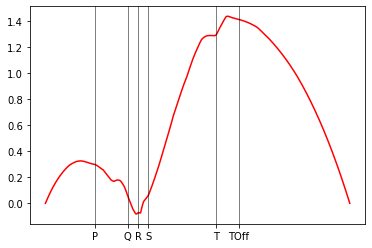

In [21]:
mean_F_7_12 = stats.trim_mean(
    warping_7_12.data_matrix[: len(land_F_7_12), :, 0], 0.05, axis=0
)
mean_M_7_12 = stats.trim_mean(
    warping_7_12.data_matrix[len(land_F_7_12) :, :, 0], 0.05, axis=0
)

fig1 = plt.figure()
plt.plot((mean_F_7_12 - mean_M_7_12) * 100, "r")
for v in np.mean(land_7_12, axis=0):
    plt.axvline(x=v * SAMPLING_RATE, color="k", lw=0.5)

plt.xticks(
    np.mean(land_7_12, axis=0) * SAMPLING_RATE, ["P", "Q", "R", "S", "T", "TOff"]
)


([<matplotlib.axis.XTick at 0x7fcfc0735130>,
 [Text(77.78333333333333, 0, 'P'),
  Text(129.48333333333332, 0, 'Q'),
  Text(147.15, 0, 'R'),
  Text(162.6, 0, 'S'),
  Text(266.95, 0, 'T'),
  Text(301.8666666666667, 0, 'TOff')])

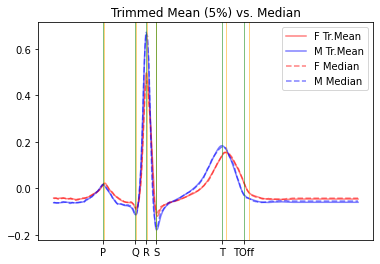

In [22]:
t_mean_F_7_12 = stats.trim_mean(fd_registered_F_7_12.data_matrix[:, :, 0], 0.05, axis=0)
t_mean_M_7_12 = stats.trim_mean(fd_registered_M_7_12.data_matrix[:, :, 0], 0.05, axis=0)
t_median_F_7_12 = np.median(fd_registered_F_7_12.data_matrix[:, :, 0], axis=0)
t_median_M_7_12 = np.median(fd_registered_M_7_12.data_matrix[:, :, 0], axis=0)

fig1 = plt.figure()
plt.title("Trimmed Mean (5%) vs. Median")
plt.plot(t_mean_F_7_12, "r", alpha=0.5, label="F Tr.Mean")
plt.plot(t_mean_M_7_12, "b", alpha=0.5, label="M Tr.Mean")
plt.plot(t_median_F_7_12, "r--", alpha=0.5, label="F Median")
plt.plot(t_median_M_7_12, "b--", alpha=0.5, label="M Median")

plt.legend()

for v in np.mean(land_F_7_12, axis=0):
    plt.axvline(x=v * SAMPLING_RATE, color="orange", lw=0.5)

plt.xticks(
    np.mean(land_F_7_12, axis=0) * SAMPLING_RATE, ["P", "Q", "R", "S", "T", "TOff"]
)
for v in np.mean(land_M_7_12, axis=0):
    plt.axvline(x=v * SAMPLING_RATE, color="green", lw=0.5)

plt.xticks(
    np.mean(land_M_7_12, axis=0) * SAMPLING_RATE, ["P", "Q", "R", "S", "T", "TOff"]
)

Text(0.5, 1.0, 'Subjects 07-12')

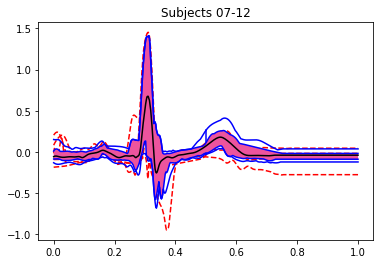

In [23]:
fdBoxplot_7_12 = Boxplot(fd_registered_7_12)
fdBoxplot_7_12.plot()
plt.title("Subjects 07-12")

Text(0.5, 1.0, 'Male Subjects')

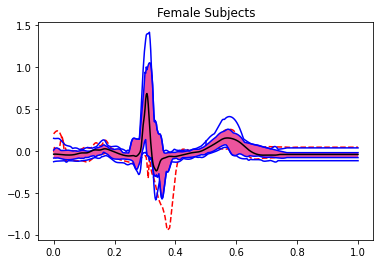

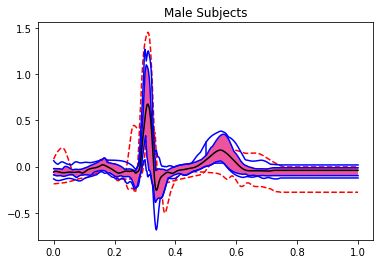

In [24]:
fdBoxplot_F_7_12 = Boxplot(fd_registered_F_7_12)
fdBoxplot_F_7_12.plot()
plt.title("Female Subjects")

fdBoxplot_M_7_12 = Boxplot(fd_registered_M_7_12)
fdBoxplot_M_7_12.plot()
plt.title("Male Subjects")


Text(0.5, 1.0, 'Female Subjects')

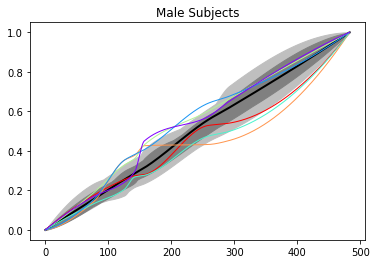

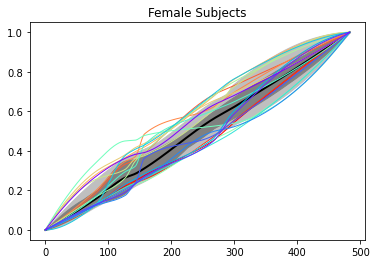

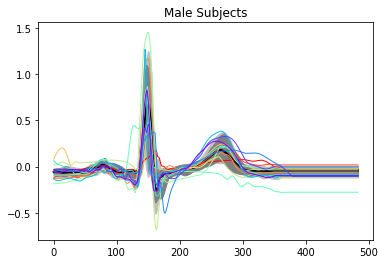

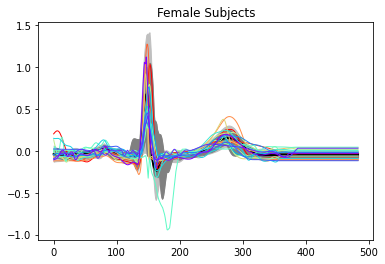

In [25]:
sm.graphics.fboxplot(warping_M_7_12.data_matrix[:, :, 0], wfactor=2.5)
plt.title("Male Subjects")
sm.graphics.fboxplot(warping_F_7_12.data_matrix[:, :, 0], wfactor=2.5)
plt.title("Female Subjects")

sm.graphics.fboxplot(fd_registered_M_7_12.data_matrix[:, :, 0], wfactor=2.5)
plt.title("Male Subjects")
sm.graphics.fboxplot(fd_registered_F_7_12.data_matrix[:, :, 0], wfactor=2.5)
plt.title("Female Subjects")


MALE:  84.70380717280077
Female:  81.13609603388606


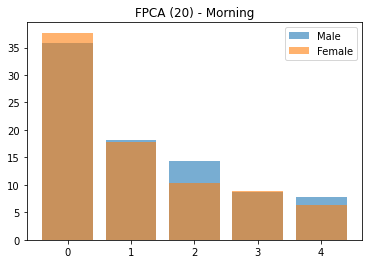

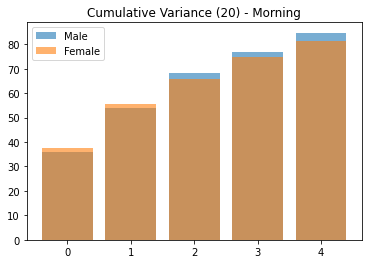

In [26]:
n = 5

fpca = FPCA(n_components=n)
fpca.fit(fd_registered_M_7_12)

evr_M_7_12 = fpca.explained_variance_ratio_ * 100

plt.bar(range(n), evr_M_7_12, alpha=0.6, label="Male")

print("MALE:  " + str(np.sum(evr_M_7_12[:5])))

fpca = FPCA(n_components=n)
fpca.fit(fd_registered_F_7_12)

evr_F_7_12 = fpca.explained_variance_ratio_ * 100

plt.bar(range(n), evr_F_7_12, alpha=0.6, label="Female")
plt.title("FPCA (20) - Morning")
plt.legend()

print("Female:  " + str(np.sum(evr_F_7_12[:5])))

plt.figure()
plt.bar(range(n), np.cumsum(evr_M_7_12), alpha=0.6, label="Male")
plt.bar(range(n), np.cumsum(evr_F_7_12), alpha=0.6, label="Female")
plt.title("Cumulative Variance (20) - Morning")
plt.legend()


In [27]:
# Finite differences: forward approximation

Text(0.5, 1.0, 'Female Subjects ∂y/∂x')

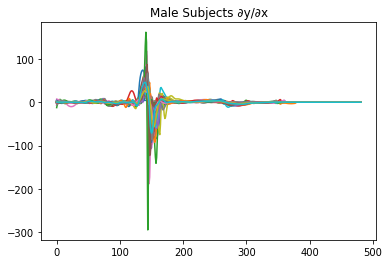

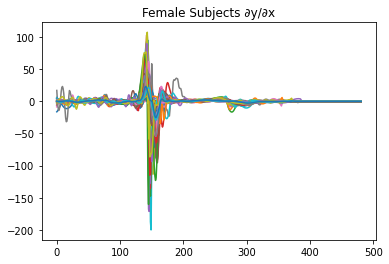

In [28]:
x = fd_registered_M_7_12.grid_points[0]
y = fd_registered_M_7_12.data_matrix
y = y.reshape(y.shape[0], y.shape[1])

dydx_M = centeredFiniteDistance2D(x, y)

plt.figure()
plt.plot(dydx_M.T)
plt.title("Male Subjects ∂y/∂x")

x = fd_registered_F_7_12.grid_points[0]
y = fd_registered_F_7_12.data_matrix
y = y.reshape(y.shape[0], y.shape[1])

dydx_F = centeredFiniteDistance2D(x, y)

plt.figure()
plt.plot(dydx_F.T)
plt.title("Female Subjects ∂y/∂x")


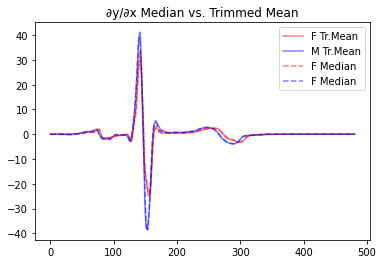

In [29]:
df_t_mean_F_7_12 = stats.trim_mean(dydx_F, 0.05, axis=0)
df_t_mean_M_7_12 = stats.trim_mean(dydx_M, 0.05, axis=0)
df_t_median_F_7_12 = np.median(dydx_F, axis=0)
df_t_median_M_7_12 = np.median(dydx_M, axis=0)

plt.figure()
plt.title("∂y/∂x Median vs. Trimmed Mean")
plt.plot(df_t_mean_F_7_12, "r", alpha=0.5, label="F Tr.Mean")
plt.plot(df_t_mean_M_7_12, "b", alpha=0.5, label="M Tr.Mean")
plt.plot(df_t_median_F_7_12, "r--", alpha=0.5, label="F Median")
plt.plot(df_t_median_M_7_12, "b--", alpha=0.5, label="F Median")
plt.legend()


Text(0.5, 1.0, 'Female Subjects $∂^2y/∂x^2$')

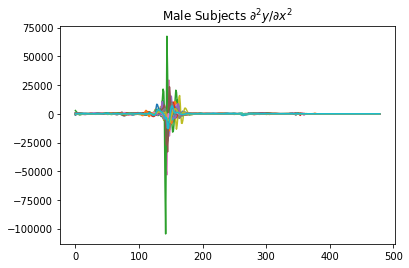

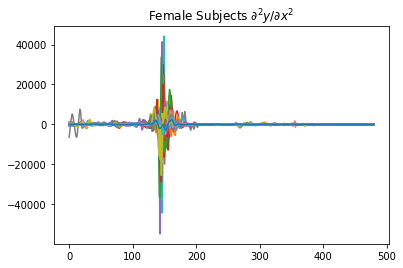

In [30]:
dydx2_M = centeredFiniteDistance2D(x, dydx_M)

plt.figure()
plt.plot(dydx2_M.T)
plt.title("Male Subjects $∂^2y/∂x^2$")

dydx2_F = centeredFiniteDistance2D(x, dydx_F)

plt.figure()
plt.plot(dydx2_F.T)
plt.title("Female Subjects $∂^2y/∂x^2$")


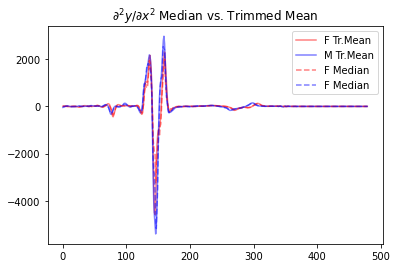

In [31]:
df2_t_mean_F_7_12 = stats.trim_mean(dydx2_F, 0.05, axis=0)
df2_t_mean_M_7_12 = stats.trim_mean(dydx2_M, 0.05, axis=0)
df2_t_median_F_7_12 = np.median(dydx2_F, axis=0)
df2_t_median_M_7_12 = np.median(dydx2_M, axis=0)

plt.figure()
plt.title("$∂^2y/∂x^2$ Median vs. Trimmed Mean")
plt.plot(df2_t_mean_F_7_12, "r", alpha=0.5, label="F Tr.Mean")
plt.plot(df2_t_mean_M_7_12, "b", alpha=0.5, label="M Tr.Mean")
plt.plot(df2_t_median_F_7_12, "r--", alpha=0.5, label="F Median")
plt.plot(df2_t_median_M_7_12, "b--", alpha=0.5, label="F Median")
plt.legend()


Text(0.5, 1.0, 'Female Subjects')

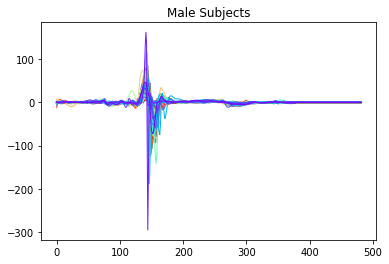

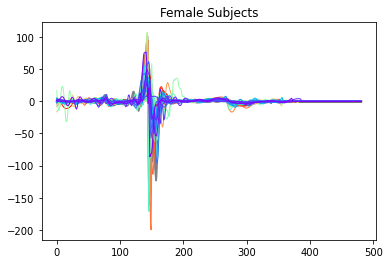

In [32]:
sm.graphics.fboxplot(dydx_M, wfactor=2.5)
plt.title("Male Subjects")
sm.graphics.fboxplot(dydx_F, wfactor=2.5)
plt.title("Female Subjects")


Text(0.5, 1.0, 'Female Subjects')

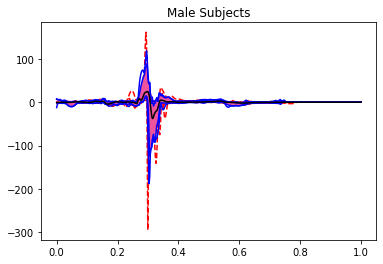

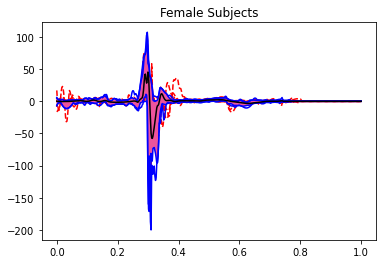

In [33]:
dydx_M = skfda.FDataGrid(dydx_M)
fdBoxplot_M_7_12 = Boxplot(dydx_M)
# fdBoxplot_M_7_12.show_full_outliers = True
fdBoxplot_M_7_12.plot()
plt.title("Male Subjects")

dydx_F = skfda.FDataGrid(dydx_F)
fdBoxplot_F_7_12 = Boxplot(dydx_F)
# fdBoxplot_M_7_12.show_full_outliers = True
fdBoxplot_F_7_12.plot()
plt.title("Female Subjects")
